## Capacitated vehicle routing problem (CVRP)

### Implement a MTZ-like model for the CVRP.

In [1]:
import networkx as nx
import random
import math
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

In [2]:
k = 4       # number of vehicles
n = 20      # number of demand points

depot = 0                       
dem_points = list(range(1,n+1)) # nodes 1, 2, ..., 20

G = nx.complete_graph(n+1,nx.DiGraph())  

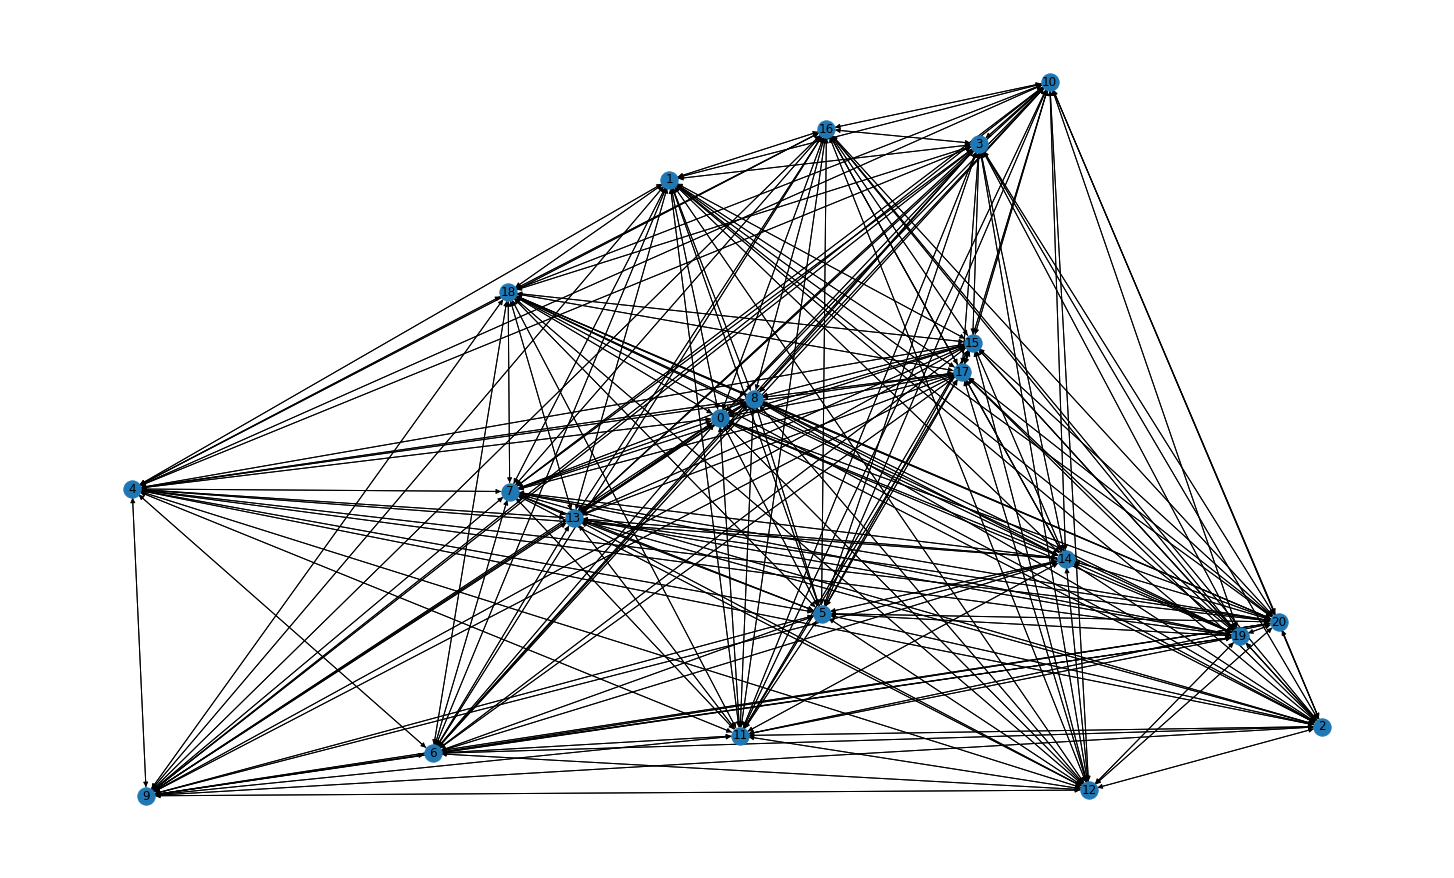

In [4]:
# pick the city (x,y)-coordinates at random
my_pos = { i : ( random.random(), random.random() ) for i in dem_points } # pos[i] = (x_i, y_i)

# let's locate the depot in the middle
my_pos[depot] = (0.5, 0.5)

plt.figure(figsize=(20,12))

nx.draw(G, pos=my_pos, with_labels="True")

In [5]:
# suppose that distances are Euclidean
def eucl_dist(x1,y1,x2,y2):
    return math.sqrt( (x1-x2)**2 + (y1-y2)**2 )

for i,j in G.edges:
    (x1,y1) = my_pos[i]
    (x2,y2) = my_pos[j]
    G.edges[i,j]['length'] = eucl_dist(x1,y1,x2,y2)

In [6]:
# suppose each vehicle has capacity 100
Q = 100

# suppose each demand point has demand 20
q = { i : 20 for i in dem_points }

In [12]:
# First, solve a relaxation

MAX_CPU_TIME = 600
EPSILON = 1.e-6

# model
model = gp.Model()
x = model.addVars(G.edges,vtype=GRB.BINARY)

model.setObjective(gp.quicksum(G.edges[i,j]['length'] * x[i,j] for i,j in G.edges), GRB.MINIMIZE)

# Enter each demand point once
model.addConstrs(gp.quicksum(x[i,j] for i in G.predecessors(j)) == 1 for j in dem_points)

# Leave each demand point once
model.addConstrs(gp.quicksum(x[i,j] for j in G.successors(i)) == 1 for i in dem_points)

# Leave the depot k times
model.addConstr(gp.quicksum(x[depot,j] for j in G.successors(depot)) == k)

# export .lp
#model.write(file_name+"_model.lp")

# parameters config
model.setParam(gp.GRB.Param.TimeLimit, MAX_CPU_TIME)
model.setParam(gp.GRB.Param.MIPGap, EPSILON)
model.setParam(gp.GRB.Param.Threads, 1)

# turn off display
gp.setParam('OutputFlag', 0)

# open log file
#_ = open('log/cvrp.log', 'w')

# solve 
model.optimize()

Set parameter TimeLimit to value 600
Set parameter MIPGap to value 1e-06
Set parameter Threads to value 1


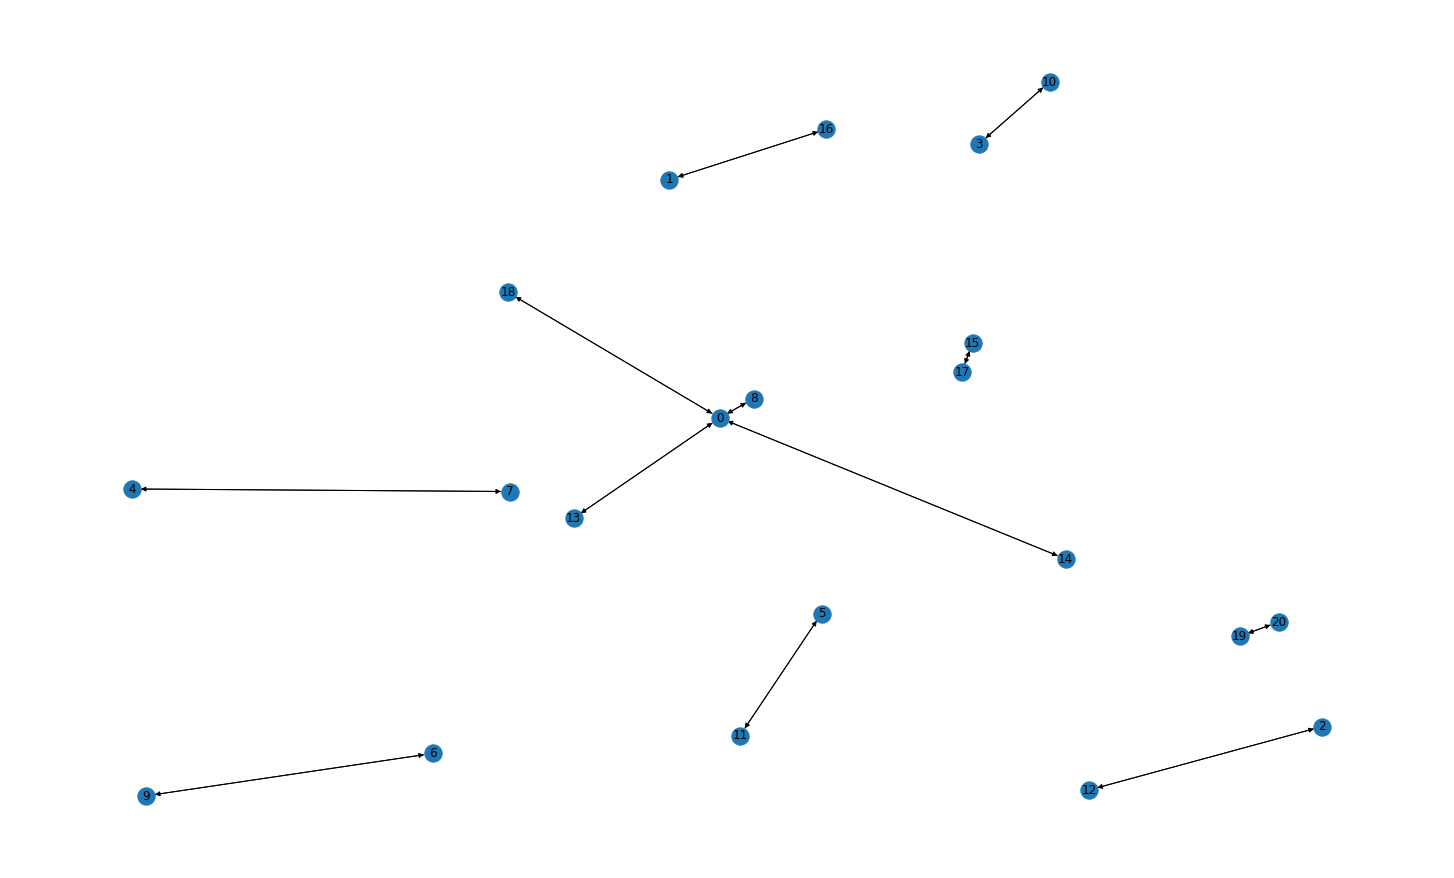

In [13]:
# get the solution and draw it
tour_edges = [ e for e in G.edges if x[e].x > 0.5 ]

plt.figure(figsize=(20,12))

nx.draw(G.edge_subgraph(tour_edges), pos=my_pos, with_labels="True")

In [14]:
# Add the MTZ variables and constraints, and solve
u = model.addVars(G.nodes)

u[depot].LB = 0
u[depot].UB = 0

for i in dem_points:
    u[i].LB = q[i]
    u[i].UB = Q

# MTZ constraint
c = model.addConstrs( u[i] - u[j] + Q * x[i,j] <= Q - q[j] for i,j in G.edges if j != depot )

# solve
model.optimize()

In [15]:
# Try again, using stronger ("lifted") version of these constraints

# remove the previous MTZ constraints
model.remove(c)  

# add stronger ("lifted") constraints
q[depot] = 0
model.addConstrs( u[i] - u[j] + Q * x[i,j] + ( Q - q[i] - q[j] ) * x[j,i] <= Q - q[j] for i,j in G.edges if j != depot )

# start solve process from scratch
model.reset()    

# solve the problem
model.optimize()

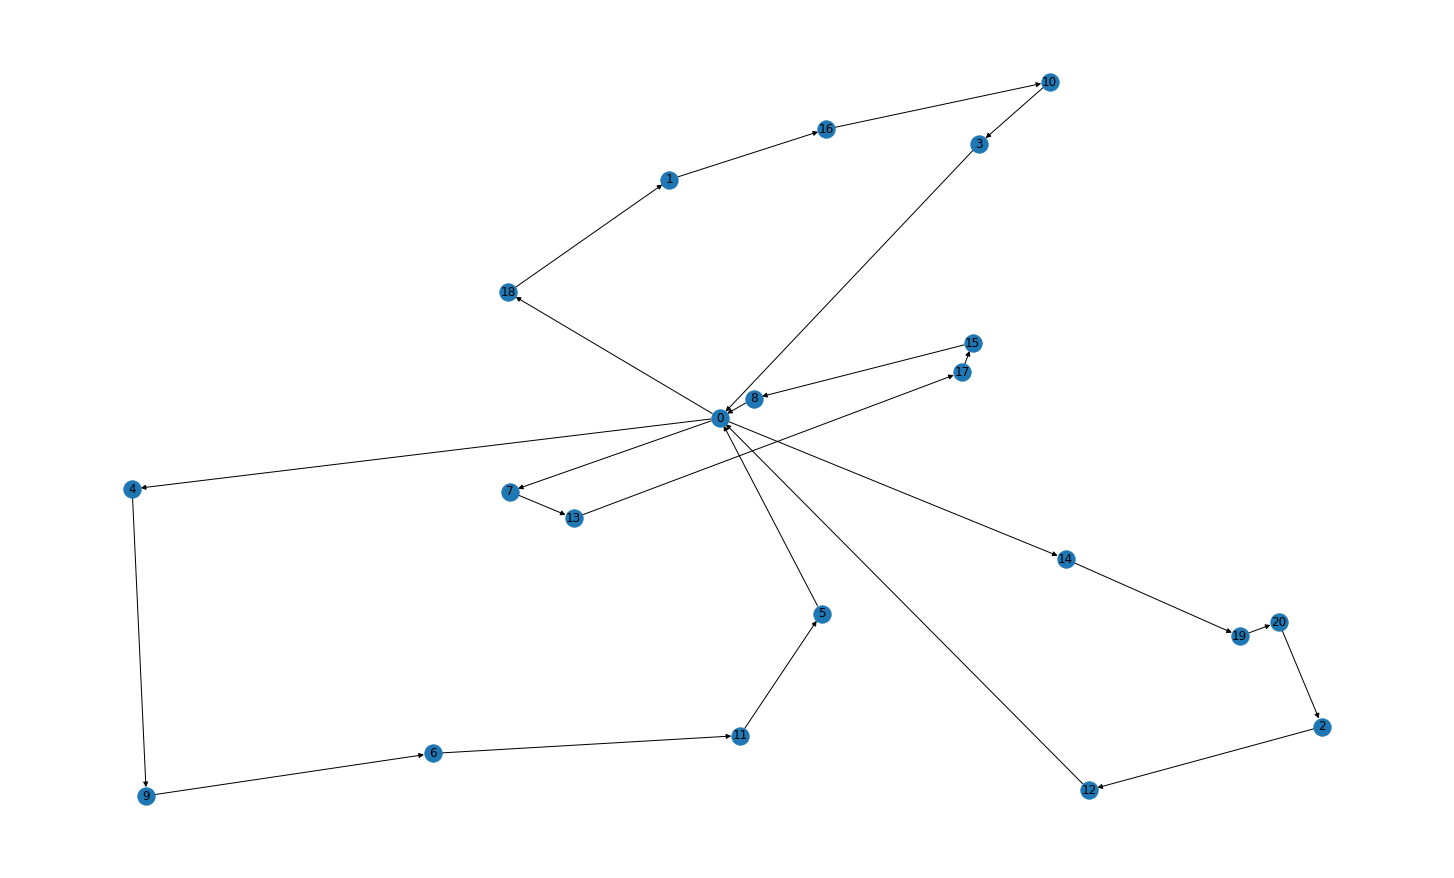

In [11]:
# get the solution and draw it
tour_edges = [ e for e in G.edges if x[e].x > 0.5 ]

plt.figure(figsize=(20,12))

nx.draw(G.edge_subgraph(tour_edges), pos=my_pos, with_labels = "True")